# 02 - ML Experimentation with Custom Model

The purpose of this notebook is to use [custom training](https://cloud.google.com/ai-platform-unified/docs/training/custom-training) to train a keras classifier to predict whether a given trip will result in a tip > 20%. The notebook covers the following tasks:
1. Preprocess the data locally using Apache Beam.
2. Train and test custom model locally using a Keras implementation.
3. Submit a Dataflow job to preprocess the data at scale.
4. Submit a custom training job to Vertex AI using a [pre-built container](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers).
5. Upload the trained model to Vertex AI.
6. Track experiment parameters from [Vertex AI Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction).

We use [Vertex TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) 
and [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction) to  track, visualize, and compare ML experiments.

## Setup

### Import libraries

In [124]:
import os
import time
import logging
from datetime import datetime
import numpy as np

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow.keras as keras

from google.cloud import aiplatform as vertex_ai
from google.cloud import aiplatform_v1beta1 as vertex_ai_beta

from src.common import features, datasource_utils
from src.model_training import data, model, defaults, trainer, exporter
from src.preprocessing import etl

logging.getLogger().setLevel(logging.INFO)
tf.get_logger().setLevel('INFO')

print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Transform: {tft.__version__}")

TensorFlow: 2.3.4
TensorFlow Transform: 0.26.0


### Setup Google Cloud project

In [131]:
PROJECT = 'aiops-industrialization' # Change to your project id.
REGION = 'us-central1' # Change to your region.
BUCKET = 'aiops-industrialization-bucket-ravi'  # Change to your bucket name.
SERVICE_ACCOUNT = "175728527123-compute@developer.gserviceaccount.com"

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Project ID: aiops-industrialization
Region: us-central1
Bucket name: aiops-industrialization-bucket-ravi
Service Account: 175728527123-compute@developer.gserviceaccount.com
Vertex API Parent URI: projects/aiops-industrialization/locations/us-central1


### Set configurations

In [132]:
VERSION = 'v01'
DATASET_DISPLAY_NAME = 'chicago-taxi-tips'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')
RAW_SCHEMA_LOCATION = 'src/raw_schema/schema.pbtxt'

TENSORBOARD_DISPLAY_NAME = f'tb-{PROJECT}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}-experiment'

## Create Vertex TensorBoard instance 

In [133]:
!gcloud beta ai tensorboards create --display-name={TENSORBOARD_DISPLAY_NAME} \
  --project={PROJECT} --region={REGION}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [3966581380812374016]...done.                            
Created Vertex AI Tensorboard: projects/175728527123/locations/us-central1/tensorboards/3380408917178712064.


In [134]:
tensorboard_client_beta = vertex_ai_beta.TensorboardServiceClient(
    client_options={"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
)

tensorboard = [
    resource for resource in tensorboard_client_beta.list_tensorboards(parent=PARENT) 
    if resource.display_name == TENSORBOARD_DISPLAY_NAME][0]

tensorboard_resource_name = tensorboard.name
print("TensorBoard resource name:", tensorboard_resource_name)

TensorBoard resource name: projects/175728527123/locations/us-central1/tensorboards/615198745973227520


## Initialize workspace

In [135]:
REMOVE_EXPERIMENT_ARTIFACTS = False

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")

Workspace is ready.


## Initialize Vertex AI experiment

In [136]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME
)

run_id = f"run-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

INFO:root:Resource chicago-taxi-tips-classifier-v01-experiment-run-local-20210830101722 not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v01-experiment-run-local-20210830101722
INFO:root:Resource chicago-taxi-tips-classifier-v01-experiment-run-local-20210830101722-metrics not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v01-experiment-run-local-20210830101722-metrics
Experiment run directory: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722


## 1. Preprocess the data using Apache Beam

The Apache Beam pipeline of data preprocessing is implemented in the [preprocessing](src/preprocessing) directory.

In [137]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

### Get Source Query from Managed Dataset

In [138]:
ML_USE = 'UNASSIGNED'
LIMIT = 5120

raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

print(raw_data_query)


    SELECT 
        IF(trip_month IS NULL, -1, trip_month) trip_month,
        IF(trip_day IS NULL, -1, trip_day) trip_day,
        IF(trip_day_of_week IS NULL, -1, trip_day_of_week) trip_day_of_week,
        IF(trip_hour IS NULL, -1, trip_hour) trip_hour,
        IF(trip_seconds IS NULL, -1, trip_seconds) trip_seconds,
        IF(trip_miles IS NULL, -1, trip_miles) trip_miles,
        IF(payment_type IS NULL, 'NA', payment_type) payment_type,
        IF(pickup_grid IS NULL, 'NA', pickup_grid) pickup_grid,
        IF(dropoff_grid IS NULL, 'NA', dropoff_grid) dropoff_grid,
        IF(euclidean IS NULL, -1, euclidean) euclidean,
        IF(loc_cross IS NULL, 'NA', loc_cross) loc_cross,
        tip_bin
    FROM playground_us.chicago_taxitrips_prep 
    WHERE ML_use = 'UNASSIGNED'
    LIMIT 5120


### Test Data Preprocessing Locally

In [139]:
args = {
    'runner': 'DirectRunner',
    'raw_data_query': raw_data_query,
    'write_raw_data': True,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': f'gs://{BUCKET}/bq_tmp',
    'project': PROJECT
}

In [140]:
vertex_ai.log_params(args)

In [141]:
print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/tmp/tftransform_tmp/92a64db3f4a448ce95bc8b7224cf56e8/saved_model.pb
INFO:tensorflow:SavedModel written to: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/tmp/tftransform_tmp/92a64db3f4a448ce95bc8b7224cf56e8/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorf

In [142]:
!gsutil ls {EXPERIMENT_RUN_DIR}

gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/exported_data/
gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/transform_artifacts/
gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/transformed_data/


## 2. Train a custom model locally using a Keras

The `Keras` implementation of the custom model is in the [model_training](src/model_training) directory.

In [143]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')
print(LOG_DIR)

gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/logs


### Read transformed data

In [144]:
tft_output = tft.TFTransformOutput(TRANSFORM_ARTIFACTS_DIR)
transform_feature_spec = tft_output.transformed_feature_spec()
transform_feature_spec

{'dropoff_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'euclidean_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'loc_cross_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'payment_type_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'pickup_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'tip_bin': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_of_week_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_hour_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_miles_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'trip_month_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_seconds_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)}

In [145]:
print(tft_output)

In [146]:
train_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'train/data-*.gz')
eval_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'eval/data-*.gz')

for input_features, target in data.get_dataset(
    train_data_file_pattern, transform_feature_spec, batch_size=3).take(1):
    for key in input_features:
        print(f"{key} {input_features[key].dtype}: {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

dropoff_grid_xf <dtype: 'int64'>: [0, 0, 0]
euclidean_xf <dtype: 'float32'>: [0.4249393939971924, -0.8341283798217773, -0.8341283798217773]
loc_cross_xf <dtype: 'int64'>: [0, 0, 0]
payment_type_xf <dtype: 'int64'>: [0, 0, 2]
pickup_grid_xf <dtype: 'int64'>: [0, 0, 0]
trip_day_of_week_xf <dtype: 'int64'>: [1, 3, 4]
trip_day_xf <dtype: 'int64'>: [27, 27, 16]
trip_hour_xf <dtype: 'int64'>: [11, 16, 1]
trip_miles_xf <dtype: 'float32'>: [-0.44292137026786804, -0.18393473327159882, -0.2579309046268463]
trip_month_xf <dtype: 'int64'>: [5, 0, 1]
trip_seconds_xf <dtype: 'float32'>: [-0.2676912248134613, -0.21505436301231384, -0.2038748413324356]
target: [0, 0, 0]


### Create hyperparameters

In [147]:
hyperparams = {
    "hidden_units": [64, 32]
}

hyperparams = defaults.update_hyperparams(hyperparams)
hyperparams

{'hidden_units': [64, 32],
 'learning_rate': 0.0001,
 'batch_size': 512,
 'num_epochs': 10}

### Create and test model inputs and outputs

In [148]:
classifier = model.create_binary_classifier(tft_output, hyperparams)
classifier.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trip_month_xf (InputLayer)      [(None,)]            0                                            
__________________________________________________________________________________________________
trip_day_xf (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
trip_day_of_week_xf (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
trip_hour_xf (InputLayer)       [(None,)]            0                                            
_______________________________________________________________________________________

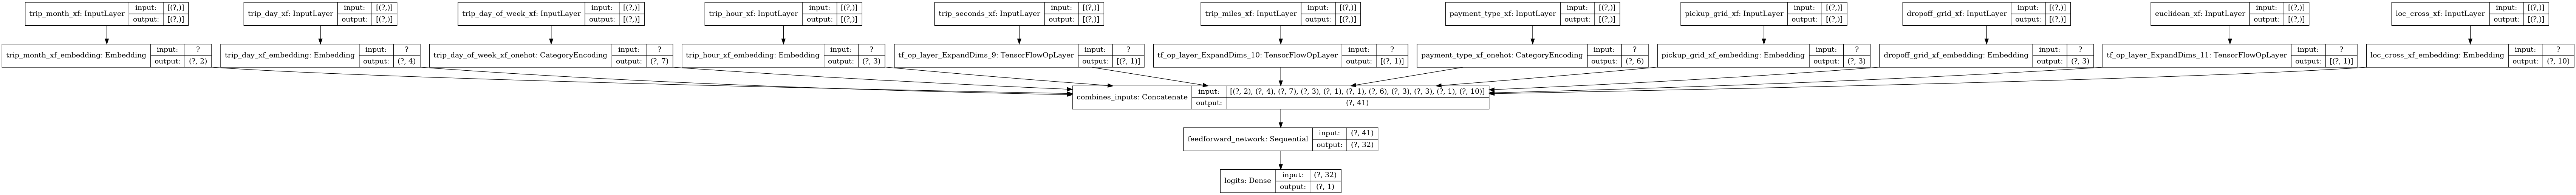

In [149]:
keras.utils.plot_model(
    classifier, 
    show_shapes=True, 
    #show_dtype=True
)

In [150]:
classifier(input_features)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.17324236],
       [-0.3298479 ],
       [-0.35724136]], dtype=float32)>

### Train the model locally.

In [151]:
logging.getLogger().setLevel(logging.INFO)

hyperparams["learning_rate"] = 0.001
hyperparams["num_epochs"] = 5
hyperparams["batch_size"] = 512

vertex_ai.log_params(hyperparams)

In [ ]:
#TRANSFORM_ARTIFACTS_DIR=os.path.join(TRANSFORM_ARTIFACTS_DIR, 'artifacts')

In [152]:
print(TRANSFORM_ARTIFACTS_DIR)

gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/transform_artifacts


In [153]:
classifier = trainer.train(
    train_data_dir=train_data_file_pattern,
    eval_data_dir=eval_data_file_pattern,
    #tft_output_dir=TRANSFORM_ARTEFACTS_DIR,
    tft_output_dir="gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830070546/transform_artifacts",
    hyperparams=hyperparams,
    log_dir=LOG_DIR,
)

INFO:root:Loading tft output from gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830070546/transform_artifacts


2021-08-30 10:23:44.163609: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


INFO:root:Model training started...
Epoch 1/5
      1/Unknown - 0s 127us/step - loss: 0.6526 - accuracy: 0.9121

2021-08-30 10:23:49.702874: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


      2/Unknown - 5s 2s/step - loss: 0.6458 - accuracy: 0.8936   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 4.5430s). Check your callbacks.


2021-08-30 10:23:52.217236: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/logs/train/plugins/profile/2021_08_30_10_23_50
2021-08-30 10:23:52.444503: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/logs/train/plugins/profile/2021_08_30_10_23_50/ravi-tensorflow-2-3-20210824-140339.trace.json.gz
2021-08-30 10:23:52.655789: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/logs/train/plugins/profile/2021_08_30_10_23_50
2021-08-30 10:23:52.901620: I tensorflow/c

8/8 [==============================] - 7s 847ms/step - loss: 0.6116 - accuracy: 0.8882 - val_loss: 0.5548 - val_accuracy: 0.8926
Epoch 2/5
8/8 [==============================] - 1s 122ms/step - loss: 0.5225 - accuracy: 0.8872 - val_loss: 0.4728 - val_accuracy: 0.8945
Epoch 3/5
8/8 [==============================] - 1s 130ms/step - loss: 0.4380 - accuracy: 0.8877 - val_loss: 0.3918 - val_accuracy: 0.8945
Epoch 4/5
8/8 [==============================] - 1s 107ms/step - loss: 0.3616 - accuracy: 0.8875 - val_loss: 0.3299 - val_accuracy: 0.8789
Epoch 5/5
8/8 [==============================] - 1s 125ms/step - loss: 0.2984 - accuracy: 0.8875 - val_loss: 0.2645 - val_accuracy: 0.8926
INFO:root:Model training completed.


In [154]:
val_loss, val_accuracy = trainer.evaluate(
    model=classifier,
    data_dir=eval_data_file_pattern,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    #tft_output_dir=TRANSFORM_ARTEFACTS_DIR,
    tft_output_dir="gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830070546/transform_artifacts",
    hyperparams=hyperparams,
)

INFO:root:Loading raw schema from src/raw_schema/schema.pbtxt
INFO:root:Loading tft output from gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830070546/transform_artifacts
INFO:root:Model evaluation started...
1/1 [==============================] - 0s 7ms/step - loss: 0.2779 - accuracy: 0.8867
INFO:root:Model evaluation completed.


In [155]:
vertex_ai.log_metrics(
    {"val_loss": val_loss, "val_accuracy": val_accuracy})

In [156]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir={LOG_DIR} \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True

INFO:tensorboard:Creating experiment
I0830 10:24:50.220969 139814179915584 uploader.py:262] Creating experiment
INFO:tensorboard:Creating experiment failed. Retrieving experiment.
I0830 10:24:50.495739 139814179915584 uploader.py:275] Creating experiment failed. Retrieving experiment.
View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+175728527123+locations+us-central1+tensorboards+615198745973227520+experiments+chicago-taxi-tips-classifier-v01-experiment
INFO:tensorboard:Starting an upload cycle
I0830 10:24:50.731917 139814179915584 uploader.py:326] Starting an upload cycle
INFO:tensorboard:Starting logdir traversal of gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/logs
I0830 10:24:50.732112 139814179915584 logdir_loader.py:68] Starting logdir traversal of gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-cl

### Export the trained model

In [157]:
saved_model_dir = os.path.join(EXPORT_DIR)

exporter.export_serving_model(
    classifier=classifier,
    serving_model_dir=saved_model_dir,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir="gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830070546/transform_artifacts",
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:root:Model export started...
INFO:tensorflow:Assets written to: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/model/assets
INFO:tensorflow:Assets written to: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/model/assets
INFO:root:Model export completed.


### Inspect model serving signatures

In [158]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_tf_example

The given SavedModel SignatureDef contains the following input(s):
  inputs['examples'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_tf_example_examples:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict


In [159]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_dropoff_grid:0
  inputs['euclidean'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_euclidean:0
  inputs['loc_cross'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_loc_cross:0
  inputs['payment_type'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_payment_type:0
  inputs['pickup_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_pickup_grid:0
  inputs['trip_day'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day:0
  inputs['trip_day_of_week'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day_of_week:0
  inputs['trip_hour'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 

### Test the exported SavedModel

In [160]:
serving_model = tf.saved_model.load(saved_model_dir)

In [161]:
file_names = tf.data.TFRecordDataset.list_files(EXPORTED_DATA_PREFIX + '/data-*.tfrecord')
for batch in tf.data.TFRecordDataset(file_names).batch(3).take(1):
    predictions = serving_model.signatures['serving_tf_example'](batch)
    for key in predictions:
        print(f"{key}: {predictions[key]}")

probabilities: [[0.11199063]
 [0.30758467]
 [0.19021818]]


In [162]:
import tensorflow_data_validation as tfdv
from tensorflow_transform.tf_metadata import schema_utils

raw_schema = tfdv.load_schema_text(RAW_SCHEMA_LOCATION)
raw_feature_spec = schema_utils.schema_as_feature_spec(raw_schema).feature_spec

In [163]:
instance = {
    "dropoff_grid": "POINT(-87.6 41.9)",
    "euclidean": 2064.2696,
    "loc_cross": "",
    "payment_type": "Credit Card",
    "pickup_grid": "POINT(-87.6 41.9)",
    "trip_miles": 1.37,
    "trip_day": 12,
    "trip_hour": 6,
    "trip_month": 2,
    "trip_day_of_week": 4,
    "trip_seconds": 555,
}

for feature_name in instance:
    dtype = raw_feature_spec[feature_name].dtype
    instance[feature_name] = tf.constant([[instance[feature_name]]], dtype)

In [164]:
predictions = serving_model.signatures['serving_default'](**instance)
for key in predictions:
    print(f"{key}: {predictions[key].numpy()}")

classes: [[b'tip<20%' b'tip>=20%']]
scores: [[0.29920864 0.70079136]]


## Start a new Vertex AI experiment run

In [165]:
vertex_ai.init(
    project=PROJECT,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME)

run_id = f"run-gcp-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

INFO:root:Resource chicago-taxi-tips-classifier-v01-experiment-run-gcp-20210830103039 not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v01-experiment-run-gcp-20210830103039
INFO:root:Resource chicago-taxi-tips-classifier-v01-experiment-run-gcp-20210830103039-metrics not found.
INFO:root:Creating Resource chicago-taxi-tips-classifier-v01-experiment-run-gcp-20210830103039-metrics
Experiment run directory: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-gcp-20210830103039


## 3. Submit a Data Processing Job to Dataflow

In [166]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

In [167]:
print(TRANSFORM_ARTIFACTS_DIR)

gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-gcp-20210830103039/transform_artifacts


In [168]:
ML_USE = 'UNASSIGNED'
LIMIT = 1000000
raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

args = {
    'runner': 'DataflowRunner',
    'raw_data_query': raw_data_query,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'write_raw_data': False,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': os.path.join(WORKSPACE, 'bq_tmp'),
    'project': PROJECT,
    'region': REGION,
    'setup_file': './setup.py'
}

In [169]:
vertex_ai.log_params(args)

In [170]:
logging.getLogger().setLevel(logging.ERROR)

print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Data preprocessing started...


/opt/conda/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/tmp/tftransform_tmp/4100ce807b144aad917cb28c59e5627e/saved_model.pb
INFO:tensorflow:SavedModel written to: gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/tmp/tftransform_tmp/4100ce807b144aad917cb28c59e5627e/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to write.
Type i

KeyboardInterrupt: 

In [171]:
!gsutil ls {EXPERIMENT_RUN_DIR}

CommandException: One or more URLs matched no objects.


## 4. Submit a Custom Training Job to Vertex AI

In [175]:
TRANSFORM_ARTIFACTS_DIR="gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830070546/transform_artifacts"


### Test the training task locally

In [176]:
!python -m src.model_training.task \
    --model-dir={EXPORT_DIR} \
    --log-dir={LOG_DIR} \
    --train-data-dir={TRANSFORMED_DATA_PREFIX}/train/* \
    --eval-data-dir={TRANSFORMED_DATA_PREFIX}/eval/*  \
    --tft-output-dir={TRANSFORM_ARTIFACTS_DIR} \
    --num-epochs=5 \
    --hidden-units=32,32 \
    --experiment-name={EXPERIMENT_NAME} \
    --run-name={run_id} \
    --project={PROJECT} \
    --region={REGION} \
    --staging-bucket={BUCKET}

INFO:apache_beam.typehints.native_type_compatibility:Using Any for unsupported type: typing.Sequence[~T]
INFO:root:Python Version = 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
INFO:root:TensorFlow Version = 2.3.4
INFO:root:TF_CONFIG = Not found
2021-08-30 10:42:24.372096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200130000 Hz
2021-08-30 10:42:24.372390: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56315cffd140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-30 10:42:24.372424: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
INFO:root:DEVICES = [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 911999769099072650
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17752354152221112397
physical_device_desc: "de

### Prepare training package

In [ ]:
TRAINER_PACKAGE_DIR = os.path.join(WORKSPACE, 'trainer_packages')
TRAINER_PACKAGE_NAME = f'{MODEL_DISPLAY_NAME}_trainer'
print("Trainer package upload location:", TRAINER_PACKAGE_DIR)

In [ ]:
!rm -r src/__pycache__/
!rm -r src/.ipynb_checkpoints/
!rm -r src/raw_schema/.ipynb_checkpoints/
!rm -f {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}.tar.gz

!mkdir {TRAINER_PACKAGE_NAME}

!cp setup.py {TRAINER_PACKAGE_NAME}/
!cp -r src {TRAINER_PACKAGE_NAME}/
!tar cvf {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}
!gzip {TRAINER_PACKAGE_NAME}.tar
!gsutil cp {TRAINER_PACKAGE_NAME}.tar.gz {TRAINER_PACKAGE_DIR}/
!rm -r {TRAINER_PACKAGE_NAME}
!rm -r {TRAINER_PACKAGE_NAME}.tar.gz

### Prepare the training job

In [184]:
TRAIN_RUNTIME = 'tf-cpu.2-4'
TRAIN_IMAGE = f"gcr.io/cloud-aiplatform/training/{TRAIN_RUNTIME}:latest"
print("Training image:", TRAIN_IMAGE)

Training image: gcr.io/cloud-aiplatform/training/tf-cpu.2-4:latest


In [185]:
num_epochs = 10
learning_rate = 0.001
hidden_units = "64,64"

trainer_args = [
    f'--train-data-dir={TRANSFORMED_DATA_PREFIX + "/train/*"}',
    f'--eval-data-dir={TRANSFORMED_DATA_PREFIX + "/eval/*"}',
    f'--tft-output-dir={TRANSFORM_ARTIFACTS_DIR}',
    f'--num-epochs={num_epochs}',
    f'--learning-rate={learning_rate}',
    f'--project={PROJECT}',
    f'--region={REGION}',
    f'--staging-bucket={BUCKET}',
    f'--experiment-name={EXPERIMENT_NAME}'
]

In [186]:
package_uri = os.path.join(TRAINER_PACKAGE_DIR, f'{TRAINER_PACKAGE_NAME}.tar.gz')

training_spec = [
    {
        "replica_count": 1,
        "machine_spec": {
            "machine_type": 'n1-standard-4',
            "accelerator_count": 0
    },
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": [package_uri],
            "python_module": "src.model_training.task",
            "args": trainer_args,
        }
    }
]

### Submit the training job

In [187]:
print("Submitting a custom training job...")

job_display_name = f"{TRAINER_PACKAGE_NAME}_{datetime.now().strftime('%Y%m%d%H%M%S')}"

custom_job = {
    "display_name": job_display_name,
    "job_spec": {
        "worker_pool_specs": training_spec,
        "base_output_directory": {"output_uri_prefix": EXPERIMENT_RUN_DIR},
        "service_account": SERVICE_ACCOUNT,
        "tensorboard": tensorboard_resource_name,
    }
}

job_client_beta = vertex_ai_beta.JobServiceClient(
    client_options={"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
)

job = job_client_beta.create_custom_job(
    parent=PARENT,
    custom_job=custom_job
)

print(f"Job {job.name} submitted.")

Submitting a custom training job...
Job projects/175728527123/locations/us-central1/customJobs/7809701349720850432 submitted.


### Monitor job state

In [188]:
while True:
    response = job_client_beta.get_custom_job(name=job.name)
    if response.state.name == 'JOB_STATE_SUCCEEDED':
        print("Training job completed. - Training Elapsed Time:", response.update_time - response.create_time)
        print("Training Job Time:", response.end_time - response.start_time)
        break
    elif response.state.name == 'JOB_STATE_FAILED':
        print("Training job failed!")
        break
    else:
        print(f"Training job state is: {response.state.name}.")
    time.sleep(60)

Training job state is: JOB_STATE_PENDING.
Training job state is: JOB_STATE_PENDING.
Training job state is: JOB_STATE_PENDING.
Training job state is: JOB_STATE_PENDING.
Training job state is: JOB_STATE_PENDING.
Training job state is: JOB_STATE_PENDING.
Training job failed!


## 5. Upload exported model to Vertex AI Models

In [177]:
!gsutil ls {EXPORT_DIR}

gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/model/
gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/model/saved_model.pb
gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/model/assets/
gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/model/variables/


### Generate the Explaination metadata

In [178]:
explanation_config = features.generate_explanation_config()
explanation_config

{'inputs': {'trip_month': {'input_tensor_name': 'trip_month',
   'modality': 'categorical'},
  'trip_day': {'input_tensor_name': 'trip_day', 'modality': 'categorical'},
  'trip_day_of_week': {'input_tensor_name': 'trip_day_of_week',
   'modality': 'categorical'},
  'trip_hour': {'input_tensor_name': 'trip_hour', 'modality': 'categorical'},
  'trip_seconds': {'input_tensor_name': 'trip_seconds', 'modality': 'numeric'},
  'trip_miles': {'input_tensor_name': 'trip_miles', 'modality': 'numeric'},
  'payment_type': {'input_tensor_name': 'payment_type',
   'modality': 'categorical'},
  'pickup_grid': {'input_tensor_name': 'pickup_grid',
   'modality': 'categorical'},
  'dropoff_grid': {'input_tensor_name': 'dropoff_grid',
   'modality': 'categorical'},
  'euclidean': {'input_tensor_name': 'euclidean', 'modality': 'numeric'},
  'loc_cross': {'input_tensor_name': 'loc_cross', 'modality': 'categorical'}},
 'outputs': {'scores': {'output_tensor_name': 'scores'}},
 'params': {'sampled_shapley_att

### Upload model

In [179]:
SERVING_RUNTIME='tf2-cpu.2-4'
SERVING_IMAGE = f"gcr.io/cloud-aiplatform/prediction/{SERVING_RUNTIME}:latest"
print("Serving image:", SERVING_IMAGE)

Serving image: gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-4:latest


In [180]:
explanation_metadata = vertex_ai.explain.ExplanationMetadata(
    inputs=explanation_config["inputs"],
    outputs=explanation_config["outputs"],
)
explanation_parameters = vertex_ai.explain.ExplanationParameters(
    explanation_config["params"]
)

vertex_model = vertex_ai.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=EXPORT_DIR,
    serving_container_image_uri=SERVING_IMAGE,
    parameters_schema_uri=None,
    instance_schema_uri=None,
    explanation_metadata=explanation_metadata,
    explanation_parameters=explanation_parameters,
)

In [181]:
vertex_model.gca_resource

name: "projects/175728527123/locations/us-central1/models/6786141786168360960"
display_name: "chicago-taxi-tips-classifier-v01"
predict_schemata {
}
metadata {
}
container_spec {
  image_uri: "gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-4:latest"
}
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
create_time {
  seconds: 1630320175
  nanos: 4135000
}
update_time {
  seconds: 1630320507
  nanos: 942524000
}
etag: "AMEw9yOYZorBtKfeW4rsmHjVEBhLlzYM5cwYZlBcVOxRYjozYau5HeY5j7mFEUybXQjB"
supported_export_formats {
  id: "custom-trained"
  exportable_contents: ARTIFACT
}
artifact_uri: "gs://aiops-industrialization-bucket-ravi/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01-experiment/run-local-20210830101722/mo

## 6. Exract experiment run parameters

In [182]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df.T

,0,1,2,3,4,5,6,7,8,9,10
experiment_name,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment
run_name,run-gcp-20210830103039,run-local-20210830101722,run-local-20210830095506,run-gcp-20210830094226,run-gcp-20210830083753,run-gcp-20210830082942,run-gcp-20210830073755,run-gcp-20210830072352,run-local-20210830070546,run-local-20210830055520,run-local-20210827114240
param.experiment_name,chicago-taxi-tips-classifier-v01-experiment,NaN,NaN,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,chicago-taxi-tips-classifier-v01-experiment,NaN,NaN,NaN
param.staging_bucket,aiops-industrialization-bucket-ravi,NaN,NaN,aiops-industrialization-bucket-ravi,aiops-industrialization-bucket-ravi,aiops-industrialization-bucket-ravi,aiops-industrialization-bucket-ravi,aiops-industrialization-bucket-ravi,NaN,NaN,NaN
param.batch_size,512.0,512.0,NaN,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0
param.gcs_location,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/bq_tmp,NaN,gs://aiops-industrialization-bucket-ravi/chica...,NaN,NaN,NaN,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/bq_tmp,gs://aiops-industrialization-bucket-ravi/bq_tmp,gs://aiops-industrialization-bucket-ravi/bq_tmp
param.eval_data_dir,gs://aiops-industrialization-bucket-ravi/chica...,NaN,NaN,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,NaN,NaN,NaN
param.region,us-central1,NaN,NaN,us-central1,us-central1,us-central1,us-central1,us-central1,NaN,NaN,NaN
param.model_dir,gs://aiops-industrialization-bucket-ravi/chica...,NaN,NaN,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,gs://aiops-industrialization-bucket-ravi/chica...,NaN,NaN,NaN
param.project,aiops-industrialization,aiops-industrialization,NaN,aiops-industrialization,aiops-industrialization,aiops-industrialization,aiops-industrialization,aiops-industrialization,aiops-industrialization,aiops-industrialization,aiops-industrialization


In [183]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/vertex-ai/locations{REGION}/experiments/{EXPERIMENT_NAME}/metrics?project={PROJECT}"
)

Vertex AI Experiments:
https://console.cloud.google.com/vertex-ai/locationsus-central1/experiments/chicago-taxi-tips-classifier-v01-experiment/metrics?project=aiops-industrialization
